In [ ]:
import torch
import torchvision

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import os
os.makedirs("going_modular")

In [ ]:
def set_seeds(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
import os
import requests
from pathlib import Path
from zipfile import ZipFile

def download_data(source: str, destination: str, remove_source: bool = True) -> Path:
    data_path = Path("data/")
    data_path.mkdir(parents=True, exist_ok=True)

    image_path = data_path / destination
    if image_path.is_dir():
        print(f"Image path {image_path} already exists...")
    else:
        print(f"Did not find {image_path}, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # get the data and download, using requests
        target_file = Path(source).name
        print(f"Target file : {target_file}") # check #1
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"Downloading {target_file} from {source}")
            f.write(request.content)
        # unzip the file and extract the imformation
        with ZipFile(data_path / target_file, "r") as zip_ref:
            print("Extracting data...")
            zip_ref.extractall(image_path)
        if remove_source:
            os.remove(data_path / target_file)
    return image_path



In [ ]:
source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
destination="pizza_steak_sushi"
image_path = download_data(source=source, destination=destination)

Did not find data/pizza_steak_sushi, creating one...
Target file : pizza_steak_sushi.zip
Extracting data...


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
%%writefile going_modular/data_setup.py

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def data_setup(train_dir: str,
               test_dir: str,
               transform: transforms.Compose,
               batch_size: int,
               num_workers: int = NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(train_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS,
                                  pin_memory=True)
    test_dataloader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS,
                                 pin_memory=True)
8
    return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


In [ ]:
# transform as per the paper
from torchvision import transforms
IMG_SIZE = 224
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [ ]:
from going_modular import data_setup
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.data_setup(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transform,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7901bc738520>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# visualize a single image
image_batch, label_batch = next(iter(train_dataloader))
# get a single image
image, label = image_batch[0], label_batch[0]
print(f"Image shape: {image.shape}, Label: {label}")

Image shape: torch.Size([3, 224, 224]), Label: 0


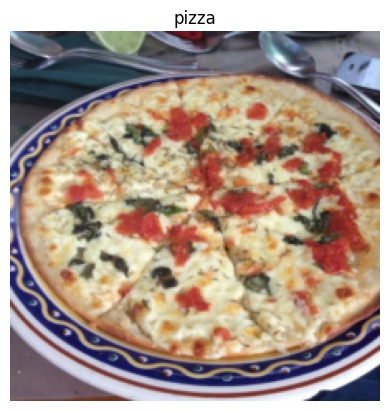

In [ ]:
# plot the image using matplot lib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# calculating patch embedding input and output shape by hand
# creating example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate num patches
number_of_patches = int((height * width) / patch_size ** 2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# output shape
embedding_layer_output_shape = (number_of_patches, patch_size ** 2 * color_channels)
print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


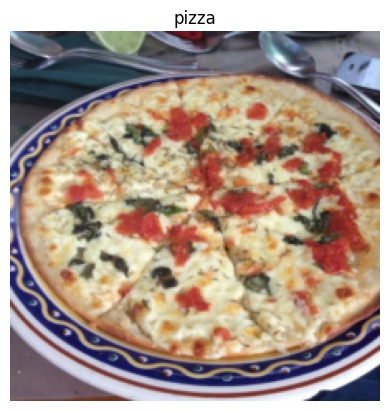

In [ ]:
# view single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

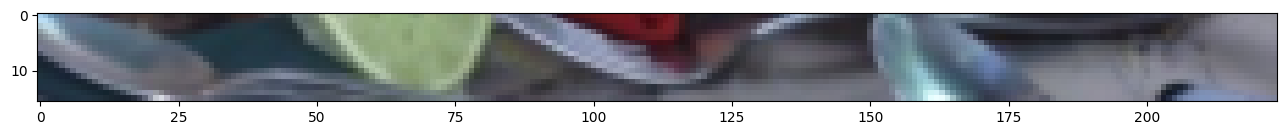

In [ ]:
# Change image shape to be compatible with matplotlib
# (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# index to plot the top row of the patched pixel.
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


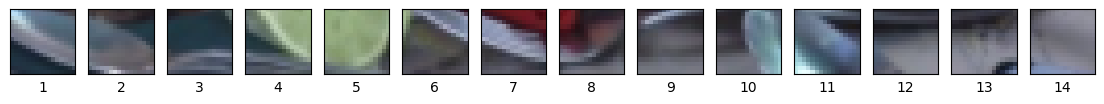

In [ ]:
# set up hyperparameters
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")
# create axis for subplots
fig, axs = plt.subplots(nrows=1,
                        ncols = img_size // patch_size,
                        figsize = (num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# iterate through nunber of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    # print(i,patch)
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


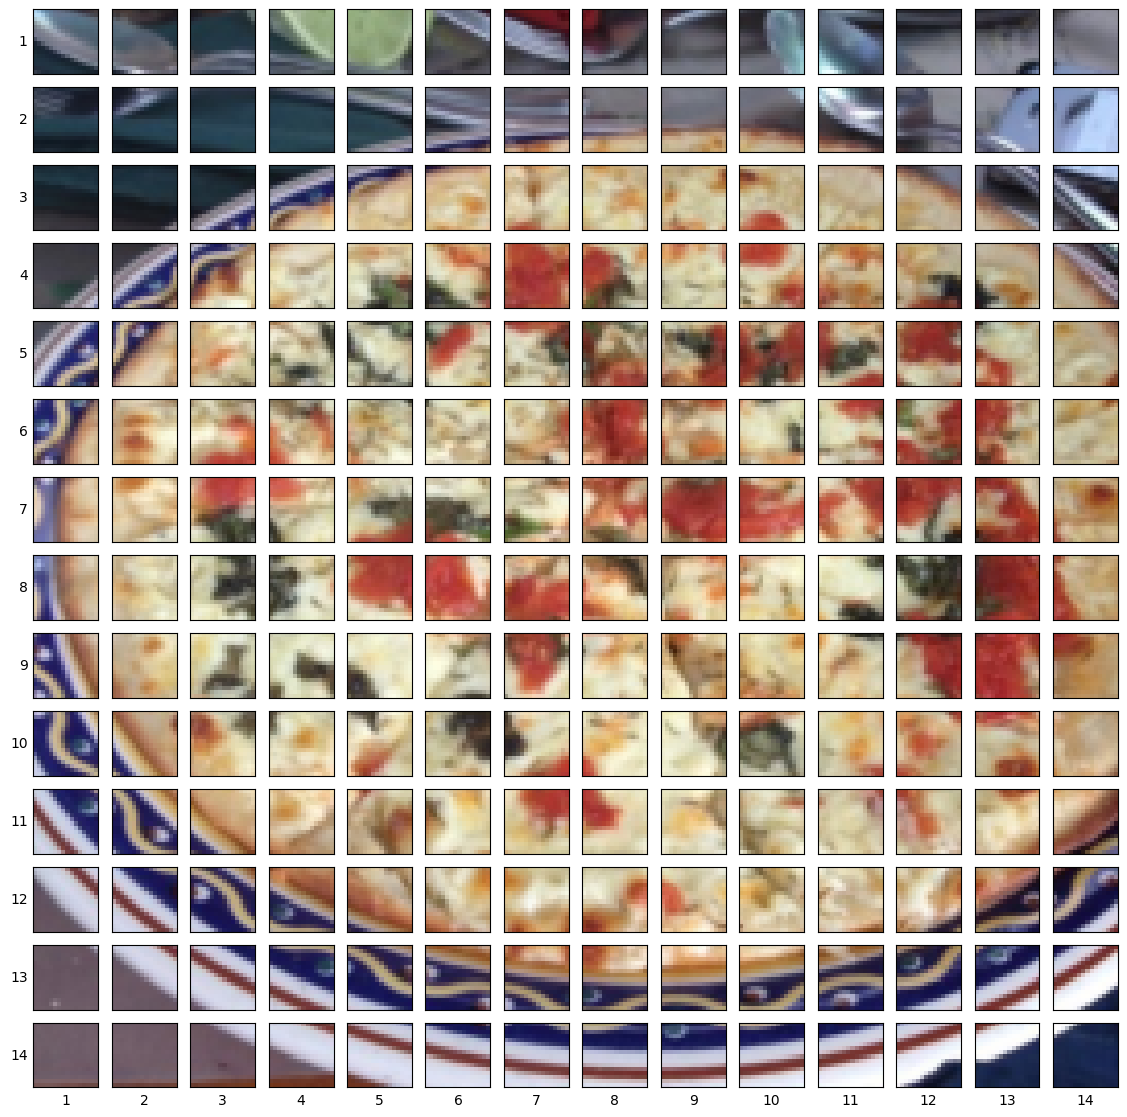

In [ ]:
# now doing it for the whole image
# set up hyperparameter
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
# but this time we ad the ycols feature
fix, axs = plt.subplots(nrows= img_size // patch_size,
                        ncols = img_size // patch_size,
                        figsize=(num_patches,num_patches),
                        sharex=True,
                        sharey=True)
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #height
                         patch_width:patch_width+patch_size, #widths
                         :]) #gets all the color channels
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchfied", fontsize=16)
plt.show()

In [ ]:
from torch import nn
# set the patch size
patch_size = 16
# creating a conv 2d layer with hyperparameters from the vit paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)


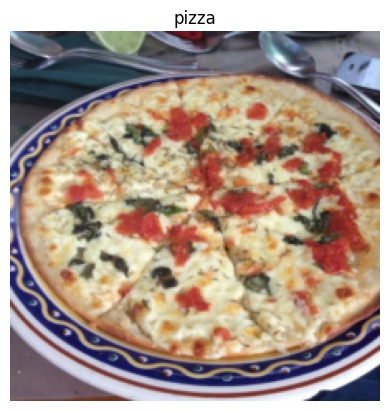

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# pass the image through the conv layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Shape of image after conv layer: {image_out_of_conv.shape}")

Shape of image after conv layer: torch.Size([1, 768, 14, 14])


Random imdexes [720, 152, 0, 357, 671]


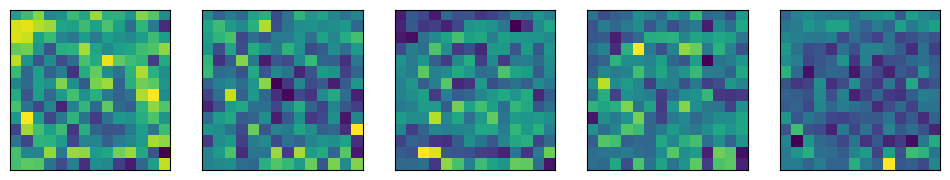

In [ ]:
# plot 5 random conv feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Random imdexes {random_indexes}")
# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# plot the random images
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# getting a single feature map from the tensor
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.1464, 0.2798, 0.2402, 0.1416, 0.3248, 0.2624, 0.2679, 0.2004,
           0.2321, 0.2742, 0.3890, 0.3452, 0.4488, 0.3914],
          [0.1620, 0.2807, 0.2005, 0.2210, 0.1602, 0.2371, 0.4420, 0.4625,
           0.4341, 0.3641, 0.0928, 0.1970, 0.4197, 0.4932],
          [0.1410, 0.1205, 0.3456, 0.4130, 0.4863, 0.5713, 0.4801, 0.4997,
           0.3858, 0.4757, 0.4527, 0.4432, 0.4391, 0.4138],
          [0.2473, 0.3809, 0.3434, 0.5839, 0.4314, 0.2048, 0.2537, 0.1714,
           0.4586, 0.4605, 0.2733, 0.4612, 0.2787, 0.4488],
          [0.4400, 0.3717, 0.4458, 0.2998, 0.2126, 0.4174, 0.5108, 0.2196,
           0.4187, 0.2122, 0.3724, 0.3853, 0.3270, 0.4303],
          [0.4178, 0.3762, 0.5955, 0.3883, 0.4124, 0.5049, 0.4455, 0.3342,
           0.3535, 0.5805, 0.4886, 0.4646, 0.2882, 0.4151],
          [0.3903, 0.4470, 0.2968, 0.3825, 0.5921, 0.1675, 0.1958, 0.4560,
           0.2545, 0.3083, 0.3445, 0.3009, 0.4221, 0.3668],
          [0.3900, 0.4270, 0.4772, 0.2106, 0.3814, 0.29

In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# create a flatten layer
flatten = nn.Flatten(start_dim=2, #flatten feature_map_height (dimention 2)
                     end_dim=3) #flatten feature_map_width (dimention 3)

Original image shape: torch.Size([3, 224, 224])
image feature map shape: torch.Size([1, 768, 14, 14])
Flattened feature map shape: torch.Size([1, 768, 196])


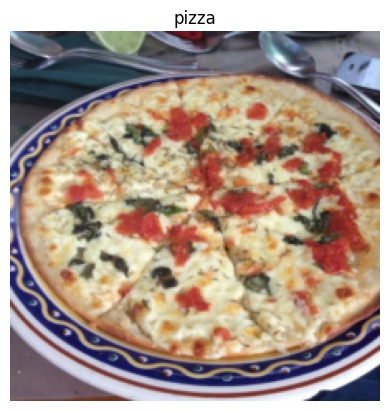

In [ ]:
#1 view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

#2 turn the image into feature by passing them into the conv2d layer
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"image feature map shape: {image_out_of_conv.shape}")

#3 flatten the feature map
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened feature map shape: {image_out_of_conv_flattened.shape}")

In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


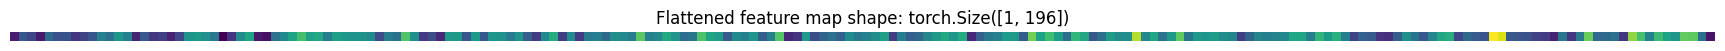

In [ ]:
# get a single flatten image
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0] # index: (batch_size, number_of_patches, embedding_dimension)

# plot the image
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.1464, 0.2798, 0.2402, 0.1416, 0.3248, 0.2624, 0.2679, 0.2004, 0.2321,
          0.2742, 0.3890, 0.3452, 0.4488, 0.3914, 0.1620, 0.2807, 0.2005, 0.2210,
          0.1602, 0.2371, 0.4420, 0.4625, 0.4341, 0.3641, 0.0928, 0.1970, 0.4197,
          0.4932, 0.1410, 0.1205, 0.3456, 0.4130, 0.4863, 0.5713, 0.4801, 0.4997,
          0.3858, 0.4757, 0.4527, 0.4432, 0.4391, 0.4138, 0.2473, 0.3809, 0.3434,
          0.5839, 0.4314, 0.2048, 0.2537, 0.1714, 0.4586, 0.4605, 0.2733, 0.4612,
          0.2787, 0.4488, 0.4400, 0.3717, 0.4458, 0.2998, 0.2126, 0.4174, 0.5108,
          0.2196, 0.4187, 0.2122, 0.3724, 0.3853, 0.3270, 0.4303, 0.4178, 0.3762,
          0.5955, 0.3883, 0.4124, 0.5049, 0.4455, 0.3342, 0.3535, 0.5805, 0.4886,
          0.4646, 0.2882, 0.4151, 0.3903, 0.4470, 0.2968, 0.3825, 0.5921, 0.1675,
          0.1958, 0.4560, 0.2545, 0.3083, 0.3445, 0.3009, 0.4221, 0.3668, 0.3900,
          0.4270, 0.4772, 0.2106, 0.3814, 0.2983, 0.3163, 0.4057, 0.4603, 0.5050,
          0.4453

In [ ]:
# actual model architecture
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()

        # layer to convert image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        # Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Image size {image_resolution} must be divisible by patch size {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1)





In [ ]:
set_seeds()

# instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
# Pass a single image through
print(f"Original image shape: {image.shape}")
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Original image shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
print(f'Batch size: {batch_size}, Embedding dimension: {embedding_dimension}')

# create a class token embedding as a learnable parameter that share same size as the embedding dimension D
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
# showing the first 10 examples
print(class_token[:,:,:10])
# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

Batch size: 1, Embedding dimension: 768
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
# adding the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
# print to see the results
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.2737e-01,  8.1749e-02,  3.4062e-02,  ...,  4.2828e-01,
          -2.7036e-01,  4.1517e-03],
         [-3.5813e-01, -3.4876e-02, -2.0357e-01,  ...,  3.0334e-01,
          -6.8807e-02,  1.4236e-01],
         ...,
         [-4.5931e-01,  6.5654e-02, -4.0851e-01,  ...,  3.3190e-01,
           7.4893e-04,  4.6475e-01],
         [-7.2915e-01,  4.3853e-01,  1.1846e-01,  ...,  3.1591e-01,
          -3.8844e-01,  1.4535e-02],
         [ 5.1639e-02, -7.3010e-02, -2.8630e-02,  ...,  1.3583e-01,
          -1.3112e-01,  8.9561e-02]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
print(patch_embedded_image_with_class_embedding.shape)
print(patch_embedded_image_with_class_embedding.shape[2])

torch.Size([1, 197, 768])
768


In [ ]:
# learnable 1D embedding with torch.ones()
# calcualte N (number of patches)
number_of_patches = int((height * width) / patch_size ** 2)
# get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]
# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

print(position_embedding[:,:,:10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# adding the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5726, 1.0817, 1.0341,  ..., 1.4283, 0.7296, 1.0042],
         [0.6419, 0.9651, 0.7964,  ..., 1.3033, 0.9312, 1.1424],
         ...,
         [0.5407, 1.0657, 0.5915,  ..., 1.3319, 1.0007, 1.4647],
         [0.2708, 1.4385, 1.1185,  ..., 1.3159, 0.6116, 1.0145],
         [1.0516, 0.9270, 0.9714,  ..., 1.1358, 0.8689, 1.0896]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# putting it all together
# set seeds
set_seeds()

# set the patch size
patch_size = 16

# print the shape of the original image
print(f"Image Tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# getting image tensor and batch dimension
x = image.unsqueeze(0)
print(f"Input shape with batch dimension: {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768) #all the params based on the Vit model
# passing the image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# create class token embedding
batch_size = patch_embedding.shape[0]
print(f"Batch size for class token: {batch_size}")
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)
# add pos embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image Tensor shape: torch.Size([3, 224, 224])
Input shape with batch dimension: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Batch size for class token: 1
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### LAYER NORM  (Section 5.1)


In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12, #12 head as we are cooking with ViT base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # create the Multi-Head-Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x, value=x,
                                             need_weights=False)
        return attn_output


In [ ]:
# create an instance of out class

# the final shape of patch_and_position_embedding is passed thought this
# so, output of equation is 1 is passed through equation 2
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### EQUATION 3: Multiple Preceptron (MLP)

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size=3072, #ViT base model
                 dropout:float=0.1):
        super().__init__()
        # creating a layer norm
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # for non-linearity, see what ReLU does?
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [ ]:
# creating an instance of the MLP block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# pass the output of MSAblock to the MLPblock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [ ]:
# Creating a Transformer Encoder by combining our custom made layers
# Basically a class that will create the connection and call the previous classes
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=32,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0.1):
        super().__init__()
        # MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        # MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    # forward function
    def forward(self, x):
        x = self.msa_block(x) + x # adding 'x' to have a residual connection
        x = self.mlp_block(x) + x
        return x

In [ ]:
# creating an instance of transformer block
!pip install torchinfo
from torchinfo import summary
transformer_encoder_block = TransformerEncoderBlock()
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
# combining everything and create the final model

class vit(nn.Module):
    # initialize the class with hyperparams for ViT-base model
    def __init__(self,
                 img_size:int=224, #image training resolution for
                 in_channels:int=3, #number of channels in the input, mainly color channels
                 patch_size:int=16, #Patch size for creating patches
                 num_transformer_layers:int=12, # layers from table 1 - ViT-base
                 embedding_dim:int=768, #Hidden size D
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000 #default for ImageNet
                 ):
        super().__init__()

        # 1. making sure image size is divisile by patch size
        assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}"

        # 2. calculating the number of patches (h*w) * patch_size^2
        self.num_patches = (img_size * img_size) // patch_size ** 2

        # 3. creating a lernable class embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1,1, embedding_dim),
                                            requires_grad=True) # to make sure its lernable
        # 4. creating a position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)

        # 5. creating a embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 6. creating a  PatchEmbedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        # 7. Creating a transformer block
        # (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                 num_heads=num_heads,
                 mlp_size=mlp_size,
                 mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        # 8. creating a classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    # forward function
    def forward(self, x):
        # 9. get batch size
        batch_size = x.shape[0]
        # 10. Class token embedding and expanding it to the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1) #"-1" means to infer the dimension
        # 11. Patch embedding
        x = self.patch_embedding(x)
        # 12. concating class and patch embedding
        x = torch.cat((class_token, x), dim=1)
        # 13. add position embedding to patch embedding
        x = self.position_embedding + x
        # 14. run embedding dropout
        x = self.embedding_dropout(x)
        #  15. Pass patch, position and class embedding through transformer encoder layers
        x = self.transformer_encoder(x)
        # 16. Put 0 index logit through classifier (equation 4
        x = self.classifier(x[:, 0])
        return x


In [ ]:
# example for creating class embedding and expanding over batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1,1,768))
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)


# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
# testing with a random tensor to see what happens
set_seeds()

# random tensor with same shape as a single image
random_image_tensor = torch.randn(1,3,224,224)

vit = vit(num_classes=len(class_names))
vit(random_image_tensor)

tensor([[-0.2141,  0.9420,  1.2329]], grad_fn=<AddmmBackward0>)

In [ ]:
%%writefile going_modular/engine.py
import torch
import os
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device) , y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        test_pred_logits = model(x)
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        ### New: Experiment tracking ###
        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass

    return results

Writing going_modular/engine.py


In [ ]:
# training the base vit model
from going_modular import engine
# set up the optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit = vit.to(device)
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 5.1739 | train_acc: 0.3633 | test_loss: 5.2931 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9747 | train_acc: 0.3477 | test_loss: 1.7699 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2184 | train_acc: 0.4414 | test_loss: 1.7606 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2723 | train_acc: 0.2656 | test_loss: 1.3310 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1445 | train_acc: 0.3047 | test_loss: 1.2263 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1825 | train_acc: 0.2891 | test_loss: 1.1875 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2348 | train_acc: 0.2812 | test_loss: 1.2268 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1148 | train_acc: 0.4297 | test_loss: 1.1655 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1412 | train_acc: 0.3047 | test_loss: 1.0198 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2610 | train_acc: 0.2617 | test_loss: 1.3680 | test_acc: 0.2604


In [ ]:
# testing the same thing using a pretrained model
import torchvision
print(torch.__version__)
print(torchvision.__version__)


2.3.0+cu121
0.18.0+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. get pretrained weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. set up vit model instance with pretrained weigths
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. freeze the base prams
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. change the classifier head to out requirements
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768,
                                      out_features=len(class_names)).to(device)

In [ ]:
# get the automatic transform on the weights or you can create you own transform
pretrained_vit_transform = pretrained_vit_weights.transforms()
print(pretrained_vit_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# setting up dataloader
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.data_setup(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_vit_transform,
    batch_size = 32
)

In [ ]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.8333 | train_acc: 0.6484 | test_loss: 0.6476 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.4814 | train_acc: 0.8867 | test_loss: 0.4171 | test_acc: 0.9384
Epoch: 3 | train_loss: 0.3158 | train_acc: 0.9414 | test_loss: 0.3284 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.2510 | train_acc: 0.9531 | test_loss: 0.2648 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.1998 | train_acc: 0.9531 | test_loss: 0.2421 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.1812 | train_acc: 0.9609 | test_loss: 0.2161 | test_acc: 0.9384
Epoch: 7 | train_loss: 0.1670 | train_acc: 0.9609 | test_loss: 0.2154 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.1422 | train_acc: 0.9648 | test_loss: 0.2146 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.1879 | train_acc: 0.9766 | test_loss: 0.1890 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.1341 | train_acc: 0.9570 | test_loss: 0.1774 | test_acc: 0.9583


In [ ]:
%%writefile going_modular/utils.py

import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir:str,
               model_name:str):
    """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # create target dir
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)
    # create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

Writing going_modular/utils.py


In [ ]:
from going_modular import utils
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")


[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB
